# 상위 5호가씩 사용한 ordexe 데이터로 학습한 Transformer 모델

# (1) 라이브러리 import

In [1]:
import os
import glob
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
import time

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import Callback, EarlyStopping

# (2) 데이터 불러오기

In [3]:
#현재 디렉토리 확인
os.getcwd()

'C:\\Users\\lys17\\Desktop\\InduStat\\code'

In [4]:
df = pd.read_csv("../data/final_data.csv")
df

,total_ask_size,total_bid_size,1_ask_size,1_bid_size,2_ask_size,2_bid_size,3_ask_size,3_bid_size,4_ask_size,4_bid_size,5_ask_size,5_bid_size,trade_price,trade_volume,spread,imbalance,totalSize_ratio,trade_price_10min_later
0,0.499237,0.925602,0.032215,0.005979,0.006364,0.016141,0.12224,0.063830,0.000120,0.300359,0.00102,0.080266,83658000.0,0.000100,36000.0,0.299237,1.854033,1
1,0.501627,0.896695,0.032215,0.005979,0.006364,0.016141,0.12224,0.300359,0.000120,0.080266,0.00102,0.142020,83658000.0,0.000100,36000.0,0.282530,1.787573,1
2,0.501627,0.861926,0.032215,0.000061,0.006364,0.005979,0.12224,0.016141,0.000120,0.300359,0.00102,0.080266,83658000.0,0.000100,33000.0,0.264235,1.718261,1
3,0.500431,0.861926,0.031019,0.000061,0.006364,0.005979,0.12224,0.016141,0.000120,0.300359,0.00102,0.080266,83658000.0,0.001195,33000.0,0.265345,1.722365,1
4,0.500431,0.878067,0.031019,0.000061,0.006364,0.005979,0.12224,0.032282,0.000120,0.300359,0.00102,0.080266,83658000.0,0.001195,33000.0,0.273947,1.754620,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8539356,0.964932,0.630721,0.020055,0.009224,0.020583,0.205333,0.10297,0.100730,0.131715,0.003442,0.04228,0.000434,115201000.0,0.000886,61000.0,-0.209451,0.653643,1
8539357,0.964932,0.630721,0.020055,0.009224,0.020583,0.205333,0.10297,0.100730,0.131715,0.003442,0.04228,0.000434,115201000.0,0.000886,61000.0,-0.209451,0.653643,1
8539358,0.964932,0.634150,0.020055,0.004341,0.020583,0.009224,0.10297,0.205333,0.131715,0.100730,0.04228,0.003442,115201000.0,0.000886,60000.0,-0.206858,0.657196,1
8539359,0.963627,0.588224,0.018750,0.004441,0.020583,0.009224,0.10297,0.205333,0.131715,0.100730,0.04228,0.003442,115262000.0,0.000652,60000.0,-0.241907,0.610427,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8539361 entries, 0 to 8539360
Data columns (total 18 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   total_ask_size           float64
 1   total_bid_size           float64
 2   1_ask_size               float64
 3   1_bid_size               float64
 4   2_ask_size               float64
 5   2_bid_size               float64
 6   3_ask_size               float64
 7   3_bid_size               float64
 8   4_ask_size               float64
 9   4_bid_size               float64
 10  5_ask_size               float64
 11  5_bid_size               float64
 12  trade_price              float64
 13  trade_volume             float64
 14  spread                   float64
 15  imbalance                float64
 16  totalSize_ratio          float64
 17  trade_price_10min_later  int64  
dtypes: float64(17), int64(1)
memory usage: 1.1 GB


# (3) 데이터 전처리

## (3-1) X와 y 데이터셋 분리

In [8]:
#X와 y 데이터셋 분리
X = df.drop(columns=['trade_price_10min_later']).values
y = df['trade_price_10min_later'].values #trade_price_10min_later가 target

## (3-2) 데이터 스케일링

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.46864885, -0.48818751, -0.16774026, ...,  0.63178415,
         1.07748541,  0.27778769],
       [-0.46821369, -0.50177367, -0.16774026, ...,  0.63178415,
         1.04007341,  0.24741268],
       [-0.46821369, -0.51811499, -0.16774026, ...,  0.50459123,
         0.99910666,  0.21573386],
       ...,
       [-0.38385642, -0.62516894, -0.17473259, ...,  1.64932751,
        -0.05579929, -0.2692184 ],
       [-0.384094  , -0.64675385, -0.17548293, ...,  1.64932751,
        -0.13428358, -0.29059398],
       [-0.384094  , -0.62403104, -0.17548293, ...,  1.64932751,
        -0.05026221, -0.26766337]])

## (3-3) 시퀀스 데이터 생성

In [12]:
timesteps = 10 #10개 행씩 묶어서 진행 (이 부분은 hyper-parameter로 조정 가능)
X_sequences, y_sequences = [], []

for i in range(len(X_scaled) - timesteps):
    X_sequences.append(X_scaled[i:i+timesteps]) #현재부터 다음 10개까지 데이터를 슬라이싱하여 한 묶음으로
    y_sequences.append(y[i+timesteps])

#dtype을 float64 -> float32로 변경 (메모리 문제 방지를 위해)
#float32는 소수점 7자리까지 보장
X_sequences = np.array(X_sequences, dtype=np.float32) #10개 시점의 X 데이터
y_sequences = np.array(y_sequences, dtype=np.float32) #그 다음 시점의 y값

#차원 확인
print(f'X_sequences 차원: {X_sequences.shape}')
print(f'y_sequences 차원: {y_sequences.shape}')

X_sequences 차원: (8539351, 10, 17)
y_sequences 차원: (8539351,)


## (3-4) train, test 셋 분리

In [14]:
#시퀀스 데이터의 train, test 분리는 시간 패턴에 따른 과적합 방지를 위해 비시계열성 데이터처럼 섞어서 진행해야 함
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42) #8:2 분리

#차원 확인
print(f'X_train 차원: {X_train.shape}')
print(f'y_train 차원: {y_train.shape}')
print(f'X_test 차원: {X_test.shape}')
print(f'y_test 차원: {y_test.shape}')

X_train 차원: (6831480, 10, 17)
y_train 차원: (6831480,)
X_test 차원: (1707871, 10, 17)
y_test 차원: (1707871,)


# (4) TFT 모델링

## (4-1) 모델 구조 설정

In [17]:
#TFT 모델 구성
inputs = layers.Input(shape=(timesteps, X_train.shape[2]))

#Input processing (variable selection)
processed_inputs = layers.TimeDistributed(layers.Dense(64, activation='relu'))(inputs)

# LSTM block
lstm_output = layers.LSTM(64, return_sequences=True)(processed_inputs)

#Temporal attention block
attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=64)(lstm_output, lstm_output)
attn_output = layers.LayerNormalization()(attn_output)

#Skip connection & fusion
lstm_and_attn = layers.Add()([lstm_output, attn_output])
lstm_and_attn = layers.LayerNormalization()(lstm_and_attn)

#Fully connected layers for output
flatten = layers.Flatten()(lstm_and_attn)
dense1 = layers.Dense(32, activation='relu')(flatten)
dense1 = layers.Dropout(0.3)(dense1)
outputs = layers.Dense(1, activation='sigmoid')(dense1)

#모델 생성
tft_model = models.Model(inputs=inputs, outputs=outputs)

tft_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 17)]     0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (None, 10, 64)      1152        ['input_1[0][0]']                
 ted)                                                                                             
                                                                                                  
 lstm (LSTM)                    (None, 10, 64)       33024       ['time_distributed[0][0]']       
                                                                                                  
 multi_head_attention (MultiHea  (None, 10, 64)      66368       ['lstm[0][0]',               

## (4-2) 모델 학습

Training Progress:   0%|                                                                        | 0/10 [00:00<?, ?it/s]

Epoch 1/10
106742/106742 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5025

Training Progress:  10%|███▏                            | 1/10 [40:29<6:04:28, 2429.84s/it, loss=0.693, val_loss=0.693]

106742/106742 [==============================] - 2430s 23ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6931 - val_accuracy: 0.5036
Epoch 2/10
106742/106742 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5023

Training Progress:  20%|██████                        | 2/10 [1:21:55<5:28:21, 2462.64s/it, loss=0.693, val_loss=0.693]

106742/106742 [==============================] - 2486s 23ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6931 - val_accuracy: 0.5036
Epoch 3/10
106742/106742 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5024

Training Progress:  30%|█████████                     | 3/10 [2:14:23<5:23:50, 2775.74s/it, loss=0.693, val_loss=0.693]

106742/106742 [==============================] - 3148s 29ms/step - loss: 0.6932 - accuracy: 0.5024 - val_loss: 0.6931 - val_accuracy: 0.5036


Training Progress:  30%|█████████                     | 3/10 [2:14:23<5:13:35, 2687.97s/it, loss=0.693, val_loss=0.693]


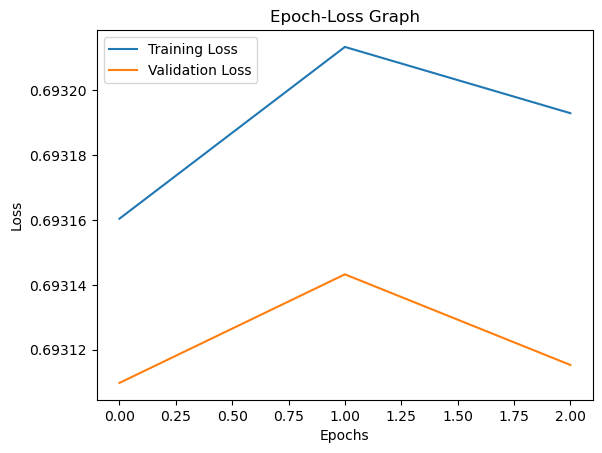

In [19]:
#모델 compile
tft_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#조기 종료(EarlyStopping) 콜백 설정
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)

#학습 시각화 및 진행 표시를 위한 Callback 설정
class TQDMProgressBar(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.tqdm = tqdm(total=self.epochs, desc='Training Progress')

    def on_epoch_end(self, epoch, logs=None):
        self.tqdm.update(1)
        self.tqdm.set_postfix(loss=logs['loss'], val_loss=logs['val_loss'])

    def on_train_end(self, logs=None):
        self.tqdm.close()

#학습 진행
history = tft_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test),
                                callbacks=[TQDMProgressBar(), early_stopping])

#Epoch-Loss 그래프 시각화
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Epoch-Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## (4-3) 모델 평가

53371/53371 [==============================] - 655s 12ms/step - loss: 0.6931 - accuracy: 0.5036
Test Loss: 0.6931, Test Accuracy: 0.5036
53371/53371 [==============================] - 467s 9ms/step


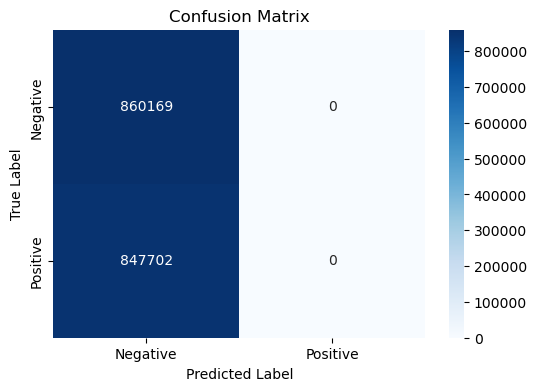

C:\Users\lys17\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lys17\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

    Negative       0.50      1.00      0.67    860169
    Positive       0.00      0.00      0.00    847702

    accuracy                           0.50   1707871
   macro avg       0.25      0.50      0.33   1707871
weighted avg       0.25      0.50      0.34   1707871



C:\Users\lys17\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
#모델 평가
loss, accuracy = tft_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

#예측값 생성
y_pred = tft_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int) #확률을 0과 1로 변환

#혼동 행렬 시각화
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 정밀도, 재현율, F1-스코어 출력
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

In [27]:
#예측된 클래스 출력
print("Predicted class labels (0 or 1):", y_pred.flatten())

Predicted class labels (0 or 1): [0 0 0 ... 0 0 0]


In [28]:
#모델 예측값
tft_model.predict(X_test)

53371/53371 [==============================] - 526s 10ms/step


array([[0.49745712],
       [0.49745712],
       [0.49745712],
       ...,
       [0.49745712],
       [0.49745712],
       [0.49745712]], dtype=float32)

# (5) 모델 저장

In [29]:
#첫 번째 파라미터 조합의 tft 모델 저장
tft_model.save("tft_1.h5")